# 2. 1D Sequential Data and DNN Models with Lag

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (06/02/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.6.2)
- Numpy (tested on v1.23.5)
- Torch (tested on v1.12.1)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Dataset generation with lag

...

In [3]:
# Our custom Dataset object
class CustomSeriesDataset(Dataset):
    def __init__(self, datapoints, lag = 2):
        self.lag = lag
        self.inputs_number = self.lag
        self.outputs_number = 1
        self.datapoints = datapoints
        self.inputs = [datapoints[i:(i + self.inputs_number)] \
                       for i in range(len(datapoints) - self.inputs_number - 1)]
        self.outputs = [datapoints[(i+self.inputs_number):(i + self.inputs_number + self.outputs_number)] \
                        for i in range(len(datapoints) - self.inputs_number - 1)]
        
    def __len__(self):
        return len(self.outputs)
        
    def __getitem__(self, index):
        inputs = torch.tensor(self.inputs[index]).float()
        outputs = torch.tensor(self.outputs[index]).float().reshape(-1)
        return inputs, outputs
    

In [4]:
# Create dataset and dataloader
np.random.seed(27)
datapoints = [np.sin(2*np.pi*i/50) for i in range(1000)]
dataset = CustomSeriesDataset(datapoints, lag = 2)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [5]:
# Fetch a datapoint
torch.manual_seed(15)
data = next(iter(dataloader))
inputs_test = data[0][0]
outputs_test = data[1][0]
print(inputs_test)
print(outputs_test)

tensor([0.9823, 0.9980])
tensor([0.9980])


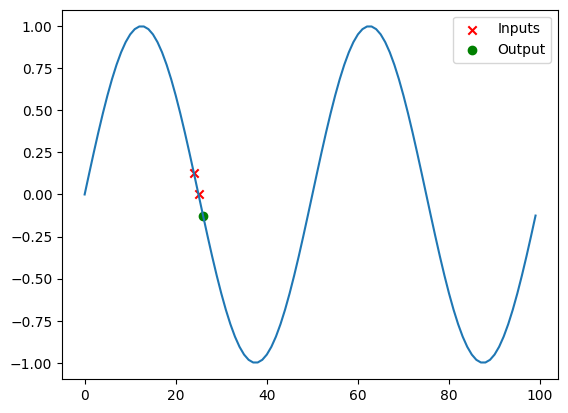

In [6]:
# Show the first 100 points
plt.plot(datapoints[:100])
plt.scatter(24, np.sin(2*np.pi/50*24), c = 'r', marker = 'x', label = 'Inputs')
plt.scatter(25, 0, c = 'r', marker = 'x')
plt.scatter(26, np.sin(2*np.pi/50*26), c = 'g', label = 'Output')
plt.legend(loc = "best")
plt.show()

### Building an autoregressive model with lag

...

In [7]:
class DNN_model_with_lag(torch.nn.Module):
    def __init__(self, lag):
        super(DNN_model_with_lag, self).__init__()
        
        # Lag
        self.lag = lag
        # Define layers
        self.layers = torch.nn.Sequential(torch.nn.Linear(self.lag, 32),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(32, 8),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(8, 1))
    
    def forward(self, inputs):
        out = self.layers(inputs)
        return out

In [8]:
model = DNN_model_with_lag(lag = 2).to(device)
print(model.layers)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)


In [9]:
# Fetch a datapoint and try out model prediction
torch.manual_seed(15)
data = next(iter(dataloader))
inputs_test = data[0]
outputs_test = data[1]
print("Inputs tensor shape: ", inputs_test.shape)
print("Targets tensor shape: ", outputs_test.shape)
pred = model(inputs_test.to(device))
print("Predicted tensor shape: ", pred.shape)

Inputs tensor shape:  torch.Size([32, 2])
Targets tensor shape:  torch.Size([32, 1])
Predicted tensor shape:  torch.Size([32, 1])


### Trainer function

...

In [10]:
def train(model, dataloader, num_epochs, learning_rate, device):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs.to(device), targets.to(device))
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

In [11]:
# Train the model
model = DNN_model_with_lag(lag = 2).to(device)
train(model, dataloader, num_epochs = 20, learning_rate = 0.01, device = device)

Epoch 1/20, Loss: 0.0489
Epoch 2/20, Loss: 0.0197
Epoch 3/20, Loss: 0.0153
Epoch 4/20, Loss: 0.0022
Epoch 5/20, Loss: 0.0034
Epoch 6/20, Loss: 0.0001
Epoch 7/20, Loss: 0.0002
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000


### Test model predictions

...

In [12]:
def test_display(seed, dataloader, model, device):
    # Fetch a datapoint
    torch.manual_seed(seed)
    data = next(iter(dataloader))
    inputs_test = data[0]
    outputs_test = data[1]

    # Display
    pred = model(inputs_test.to(device)).detach().cpu()
    fig = plt.plot(range(2), inputs_test[0], "b", label = "Inputs")
    plt.scatter(range(2, 3), outputs_test[0], c = "r", label = "Targets")
    plt.scatter(range(2, 3), pred[0], c = "g", marker = "x", label = "Predictions")
    plt.legend(loc = "best")
    plt.ylim(-1.05, 1.05)
    plt.show()

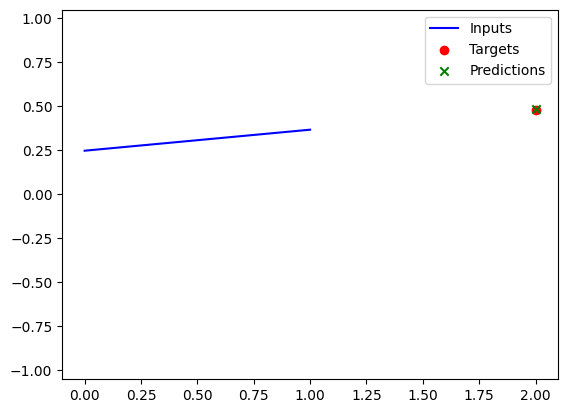

In [13]:
# Try it
test_display(seed = 5, dataloader = dataloader, model = model, device = device)

### Higher lag generation

...

In [14]:
# Create dataset and dataloader
np.random.seed(27)
datapoints = [np.sin(2*np.pi*i/50) for i in range(1000)]
dataset = CustomSeriesDataset(datapoints, lag = 10)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
# Fetch a datapoint
torch.manual_seed(15)
data = next(iter(dataloader))
inputs_test = data[0][0]
outputs_test = data[1][0]
print(inputs_test)
print(outputs_test)

tensor([ 4.8175e-01,  3.6812e-01,  2.4869e-01,  1.2533e-01,  5.3897e-15,
        -1.2533e-01, -2.4869e-01, -3.6812e-01, -4.8175e-01, -5.8779e-01])
tensor([-0.6845])


In [15]:
# Train the model
model2 = DNN_model_with_lag(lag = 10).to(device)
train(model2, dataloader, num_epochs = 20, learning_rate = 0.01, device = device)

Epoch 1/20, Loss: 0.0051
Epoch 2/20, Loss: 0.0004
Epoch 3/20, Loss: 0.0000
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000


In [16]:
def test_display2(seed, dataloader, model, device):
    # Fetch a datapoint
    torch.manual_seed(seed)
    data = next(iter(dataloader))
    inputs_test = data[0]
    outputs_test = data[1]

    # Display
    pred = model(inputs_test.to(device)).detach().cpu()
    fig = plt.plot(range(10), inputs_test[0], "b", label = "Inputs")
    plt.scatter(range(10, 11), outputs_test[0], c = "r", label = "Targets")
    plt.scatter(range(10, 11), pred[0], c = "g", marker = "x", label = "Predictions")
    plt.legend(loc = "best")
    plt.ylim(-1.05, 1.05)
    plt.show()

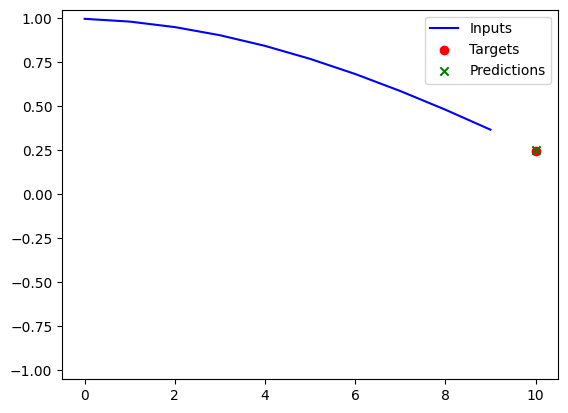

In [17]:
# Try it
test_display2(seed = 5, dataloader = dataloader, model = model2, device = device)

### What's next?

...